In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import zeus

In [4]:
# define the model function
def straight_line(x, m, c):
    ''' A straight line model: y = m*x + c '''
    return m*x + c

# set the true values of the model parameters for creating the data
m_true = 3.5 # gradient of the line
c_true = 1.2 # y-intercept of the line

# Set the x-coordinates of the data points
M = 70 # Number of data points
x = np.sort(10.0 * np.random.rand(M)) # their x-coordinates

In [5]:
# create the data - the model plus Gaussian noise
sigma = 3.0 # standard deviation of the noise
data = straight_line(x, m_true, c_true) + sigma * np.random.randn(M)

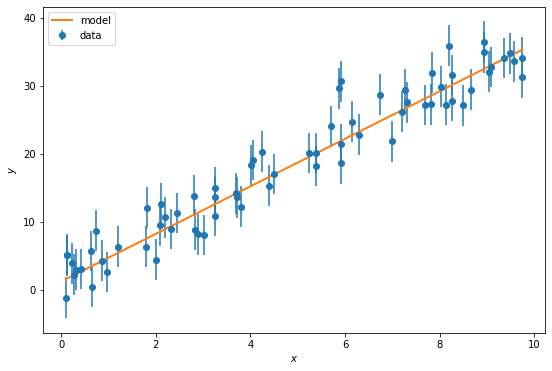

In [6]:
plt.figure(figsize=(9,6))
plt.errorbar(x, data, yerr=sigma, fmt="o", label='data')
plt.plot(x, straight_line(x, m_true, c_true), '-', lw=2, label='model')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In [7]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. '''

    lp = 0.

    # unpack the model parameters from the tuple
    m, c = theta

    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if cmin < c < cmax else -np.inf

    # Gaussian prior on m
    mmu = 3.     # mean of the Gaussian prior
    msigma = 10. # standard deviation of the Gaussian prior
    lp -= 0.5*((m - mmu)/msigma)**2

    return lp

In [8]:
def loglike(theta, data, sigma, x):
    '''The natural logarithm of the likelihood.'''

    # unpack the model parameters
    m, c = theta

    # evaluate the model
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5 * np.sum(((md - data)/sigma)**2)

In [9]:
def logpost(theta, data, sigma, x):
    '''The natural logarithm of the posterior.'''

    return logprior(theta) + loglike(theta, data, sigma, x)

In [10]:
ndim = 2 # Number of parameters/dimensions (e.g. m and c)
nwalkers = 10 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 2000 # Number of steps/iterations.

start = 0.01 * np.random.randn(nwalkers, ndim) # Initial positions of the walkers.

sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, args=[data, sigma, x]) # Initialise the sampler
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 2000/2000 [00:05<00:00, 383.55it/s]
Summary
-------
Number of Generations: 2000
Number of Parameters: 2
Number of Walkers: 10
Number of Tuning Generations: 22
Scale Factor: 0.926166
Mean Integrated Autocorrelation Time: 3.06
Effective Sample Size: 6529.18
Number of Log Probability Evaluations: 110382
Effective Samples per Log Probability Evaluation: 0.059151


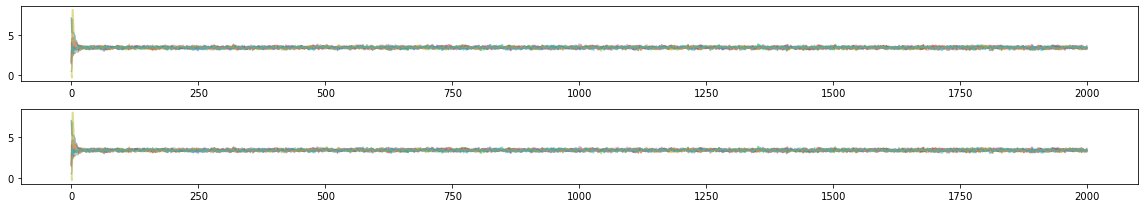

In [11]:
plt.figure(figsize=(16, 1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,0], alpha=0.5)
plt.tight_layout()
plt.show()

/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


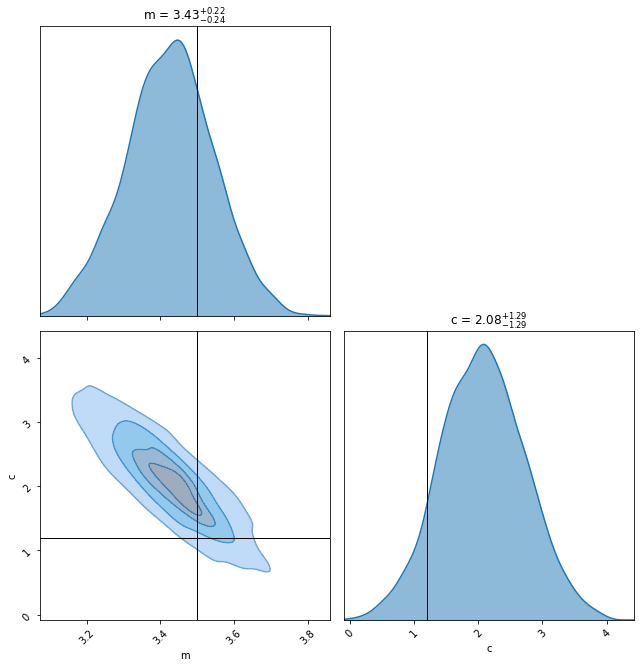

In [15]:
# flatten the chains, thin them by a factor of 10, and remove the burn-in (first half of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//2, thin=5)

# plot marginal posterior distributions
fig, axes = zeus.cornerplot(chain, labels=['m', 'c'], truth=[m_true, c_true])